In [2]:
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Data preprocessing

In [4]:
hour_df = pd.read_csv('data/hour.csv')
print('Shape of dataset::{}'.format(hour_df.shape))

Shape of dataset::(17379, 17)


In [7]:
n = 5
hour_df.head(n) # gives us an overview of the data by showing the first n-rows

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [9]:
hour_df.dtypes # datatype of all attributes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
hr              int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

In [10]:
# clean up our columns
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [12]:
# date time conversion
hour_df['datetime'] = pd.to_datetime(hour_df.datetime)

# categorical conversion
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

### Distribution and Trends

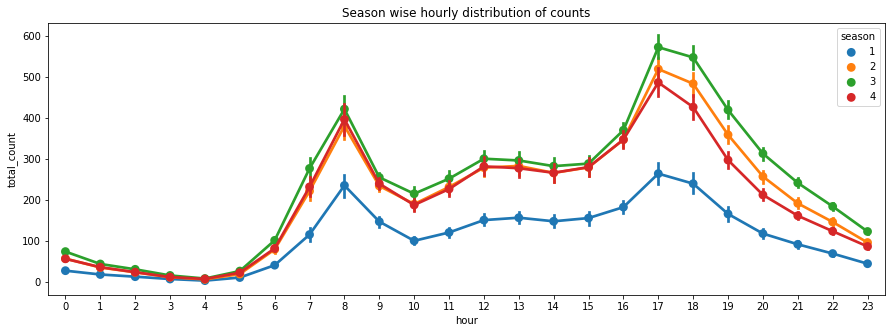

In [23]:
## summary per season, per hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(data=hour_df[['season', 'hour', 'total_count']], x='hour', y='total_count', hue='season', ax=ax)
ax.set(title='Season wise hourly distribution of counts')
plt.show()

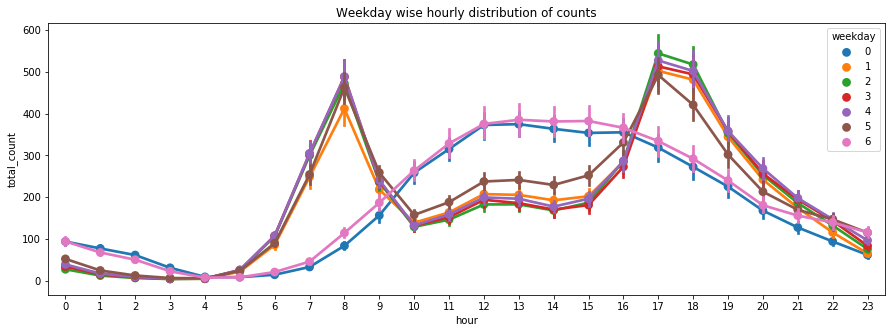

In [22]:
## summary per day of the week, per hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.pointplot(data=hour_df[['weekday', 'hour', 'total_count']], x='hour', y='total_count', hue='weekday', ax=ax)
ax.set(title='Weekday wise hourly distribution of counts')
plt.show()

[Text(0.5, 1.0, 'Monthly distribution of counts')]

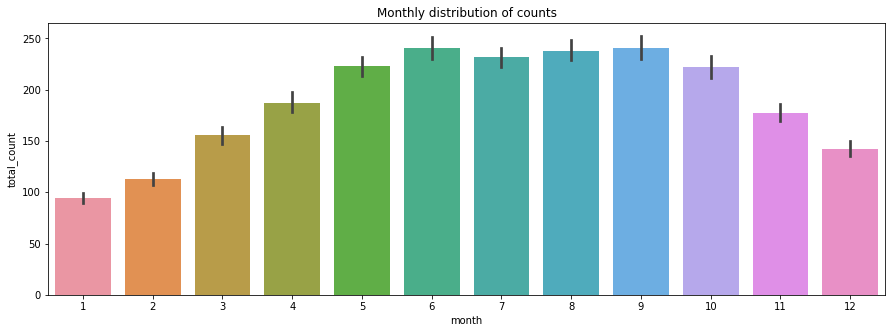

In [27]:
# total usage per month
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=hour_df[['month', 'total_count']], x='month', y='total_count')
ax.set(title='Monthly distribution of counts')

[Text(0.5, 1.0, 'Monthly distribution of counts')]

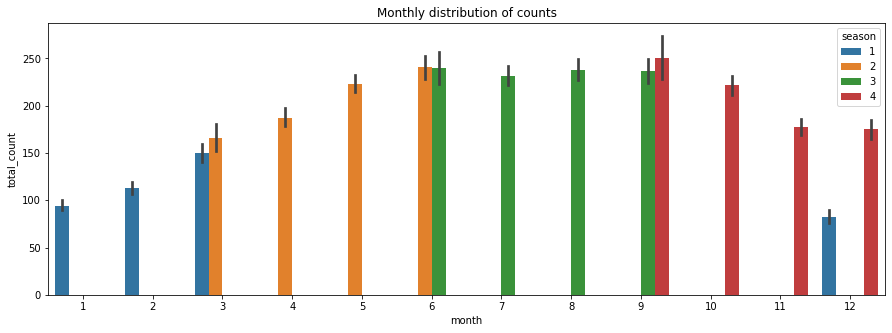

In [28]:
# per season per month
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=hour_df[['season', 'month', 'total_count']], x='month', y='total_count', hue='season', ax=ax)
ax.set(title='Monthly distribution of counts')

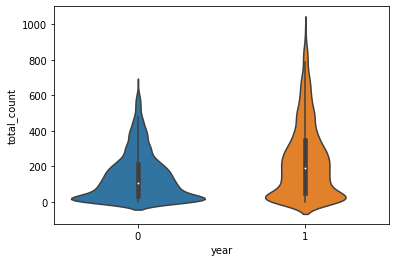

In [30]:
# distribution per year
sns.violinplot(data=hour_df[['year', 'total_count']], x='year', y='total_count')

### Outliers

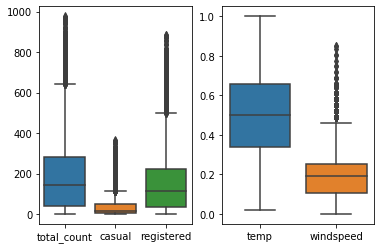

In [31]:
fig, (ax1,ax2)= plt.subplots(ncols=2)
sns.boxplot(data=hour_df[['total_count','casual','registered']],ax=ax1)
sns.boxplot(data=hour_df[['temp','windspeed']],ax=ax2)

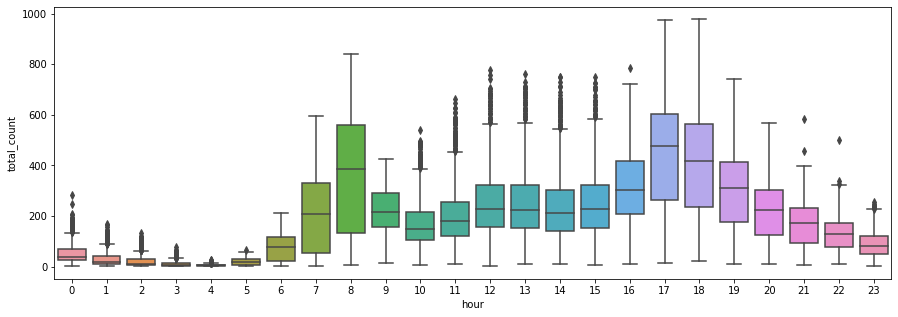

In [36]:
# outliers per hour
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxplot(data=hour_df[['hour', 'total_count']], x='hour', y='total_count')

### Correlation

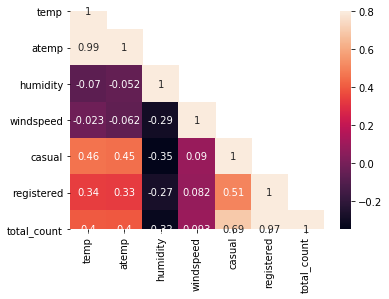

In [42]:
corrMatt = hour_df[["temp","atemp",
                    "humidity","windspeed",
                    "casual","registered",
                    "total_count"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True,annot=True)